In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt

In [1]:
from keras.layers import Dot, Embedding, Activation, Input, Reshape
from keras.models import Model
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk import word_tokenize

C:\Users\yifan\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Understanding Word2Vec

This notebook is a simplified version of word2vec. The model creates a semantic space by training a model that predicts which word appeared in the context of another word. The model won't achieve 100% accuracy - think of all the words that can appear within five words of the context "dog" and you'll see how it's an impossible objective. However, since words with similar meanings/grammar tend to have similar contexts, the embedding layer is a very useful semantic space.

This is a self-supervised task because it doesn't require separate annotation. The "annotation" for a word is the words that appear around it in a large corpus.

## Corpus to input

Real word2vec rose to prominence in large part because of how efficient it is - how it processed as much language data within hours as previous word-embedding models processed within weeks. Training data is "free" - think all of Wikipedia - because the task is self-supervised.

I'm using Moby Dick to show how the data is made and what the model looks like -- but that's much too small for a real, usable semantic space.

In [2]:
txt_fn = "mobydick.txt"

# these models require a closed vocabulary
# get word frequency from the whole corpus
vocab_count = {}
with open(txt_fn, 'r') as novel:
    for line in novel:
        tokens = word_tokenize(line.strip().lower())
        #tokens = line.strip().lower().split() #laziest possible preprocessing
        for t in tokens:
            if t not in vocab_count:
                vocab_count[t] = 0
            vocab_count[t] += 1
            
# set a threshold for frequency
min_count = 5
vocab_count = {k:v for k,v in vocab_count.items() if v>=min_count}

# typically, vocabulary is sorted with most frequent words first
vocab_list = [k for k,v in sorted(vocab_count.items(), key=lambda x:x[1], reverse=True)]

# dictionaries map strings to their indices in the list
# these will be the rows for word embeddings in our matrix
lookup = {word:i for i,word in enumerate(vocab_list)}

vocab_size = len(vocab_list)
print("{} words in vocabulary.\nMost common:{}".format(vocab_size, vocab_list[:10]))

2371 words in vocabulary.
Most common:[',', 'the', '.', 'of', 'and', 'a', 'to', 'in', ';', 'that']


## Unigram (one word) corpus probabilities

The most frequent words of language are extremely frequent. We don't need to train the embedding for "the" 234x as much as the embedding for "fish." Here, we make sampling probabilities using some code from the gensim implementation of word2vec. The frequency ranks are preserved ("the" is still more important than "fish"), but the curve is reduced.

In [3]:
# word frequency
vocab_frequencies = [vocab_count[word] for word in vocab_list]
total_tokens = sum(vocab_frequencies)

vocab_proportion = np.asarray(vocab_frequencies)/float(total_tokens)

In [4]:
scaled_prob = np.zeros((len(vocab_frequencies)))

threshold_count = 1e-3*total_tokens
print("downsampling when more frequent than {}".format(threshold_count))

for i,v in enumerate(vocab_frequencies):
    word_probability = (np.sqrt(v / threshold_count) + 1) * (threshold_count / v)
    scaled_prob[i] = min(word_probability, 1)
    
print(scaled_prob[:10],scaled_prob[-10:])

downsampling when more frequent than 112.194
[0.12029566 0.14235709 0.19685154 0.21047309 0.22202446 0.25428078
 0.2629592  0.28225839 0.29667513 0.34049365] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


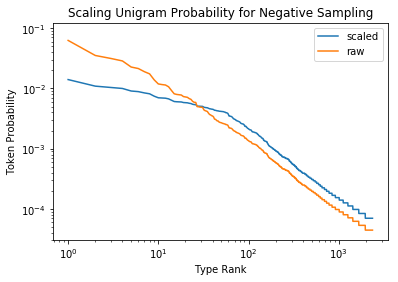

In [7]:
# This is the flattened curve

downscaled_freqs = vocab_frequencies * scaled_prob
downscaled_percents = downscaled_freqs / downscaled_freqs.sum()

plt.plot(downscaled_percents, label="scaled")
plt.plot(vocab_proportion, label="raw")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Type Rank")
plt.ylabel("Token Probability")
plt.title("Scaling Unigram Probability for Negative Sampling")
plt.legend()

## Read corpus to get context windows

Objective is to match words with their context - this is "self-supervised" and no data is held out for validation.

In [7]:
# Generator to read corpus one line at a time - don't put the whole thing in memory
# Yield center word and window of context
# THIS is where sampling happens for word2vec, effectively increasing window size
def corpus_stepper(corp_file, context_size, probabilities, lookup):
    context_needed = (context_size*2)+1
    tokens = []
    cf = open(corp_file, 'r')
    while True: # loop through forever
        if len(tokens) >=context_needed:
            left_context = tokens[:context_size]
            token = tokens[context_size]
            right_context = tokens[context_size+1:context_needed]
            yield (token,left_context+right_context)
            tokens = tokens[1:]
            #print(tokens)
        else: # get another line, possibly another file
            new_tokens = cf.readline()
            if not new_tokens: #end of file
                cf.close()
                cf = open(corp_file, 'r')
                new_tokens = cf.readline()
            line_tokens = word_tokenize(new_tokens.strip().lower())
            line_inds = [lookup[w] for w in line_tokens if w in lookup]
            #print(line_inds,line_tokens)
            # downsample using precomputed probabilities
            rand_keep = np.random.random() # 0 - 1
            line_inds = [ind for ind in line_inds if probabilities[ind]>=rand_keep]
            tokens.extend(line_inds)

In [8]:
# instantiate our corpus stepper
window = 4
context_gen = corpus_stepper(txt_fn, context_size=window, probabilities=scaled_prob, lookup=lookup)
for i in range(200): # get past some weirdness at beginning
    next(context_gen)
for i in range(10):
    w,cxt = next(context_gen)
    print(vocab_list[w])
    print([vocab_list[c] for c in cxt])

)
['whale', '(', 'supplied', 'late', 'pale', 'coat', 'heart', 'body']
pale
['(', 'supplied', 'late', ')', 'coat', 'heart', 'body', 'brain']
coat
['supplied', 'late', ')', 'pale', 'heart', 'body', 'brain', 'see']
heart
['late', ')', 'pale', 'coat', 'body', 'brain', 'see', 'now']
body
[')', 'pale', 'coat', 'heart', 'brain', 'see', 'now', 'ever']
brain
['pale', 'coat', 'heart', 'body', 'see', 'now', 'ever', 'old']
see
['coat', 'heart', 'body', 'brain', 'now', 'ever', 'old', 'queer']
now
['heart', 'body', 'brain', 'see', 'ever', 'old', 'queer', 'handkerchief']
ever
['body', 'brain', 'see', 'now', 'old', 'queer', 'handkerchief', 'gay']
old
['brain', 'see', 'now', 'ever', 'queer', 'handkerchief', 'gay', 'known']


## Negative Sampling

This model tries to assign the real context word the highest probability of the whole vocabulary. However, the vocabulary size is prohibitively large - here's it's a few thousand, but models trained on internet data have millions of vocabulary items.

Instead, we use "negative sampling." The real vocabulary item is the positive sample. The randomly chosen vocabulary items are negative samples. (They are random but have a sampling probability.)

In [9]:
#negative samples are just based on unigram frequency
vocab_size = scaled_prob.shape[0]
negative_samples = np.random.choice(vocab_size, size=(10,), p=downscaled_percents)
print(negative_samples)
print([vocab_list[i] for i in negative_samples])

[ 618  195   54  487 1460 1051   21  111   86   70]
['wonder', 'whaling', 'like', 'com-', 'proceed', 'exactly', 'all', 'men', 'only', 'though']


In [10]:
# train using a generator so we can generate new negative samples every epoch (pass through the training data)
# a larger corpus might also not fit into memory

def train_generator(corpus_gen, unigram_probabilities, num_neg):
    
    while True:
        word,contexts = next(corpus_gen)

        X = np.zeros((len(contexts), 1), dtype=np.int32)
        X += word # all of X is the same center word
        y = np.zeros((len(contexts), num_neg+1), dtype=np.int32)
        i = 0
        for context in contexts:
            y[i,0] = context # index 0 is the positive
            y[i, 1:] = np.random.choice(vocab_size,
                                size=num_neg,p=unigram_probabilities)
            i += 1
        if i == 0: # no contexts, don't feed empty array
            continue
        # truncate in case we lost some out-of-vocab contexts
        X = X[:i] 
        y = y[:i]

        target = np.zeros((i,1), dtype=np.int32) # this says "index 0 of y is always correct"
        yield ([X,y], target)


In [11]:
# instantiate the generator
tg = train_generator(context_gen, downscaled_percents, 10)

In [12]:
inputs,target = next(tg)
print("output of generator:")
print(inputs)
print("\ncenter word: {}".format(vocab_list[inputs[0][0,0]]))
print("samples:")
for word_list in inputs[1]:
    print("postitive: {}\n\tnegative: {}".format(vocab_list[word_list[0]],[vocab_list[i] for i in word_list[1:]]))

output of generator:
[array([[460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460],
       [460]], dtype=int32), array([[ 123,   92,  167, 1019,  379,   42, 1879,   14, 1270,   19,    3],
       [  48,  112,    1,  479, 2367, 2053,   10,   11, 1144, 1545, 1049],
       [ 147,  319,   31,   34,   39, 2156,  338,    2,   46,    9,   85],
       [  75,   13,  254,  443,   12,  239, 1784, 1616,   99,  226,   18],
       [1976,  647,    3,    1, 2224,   46,   13,  906,  123,   98,  695],
       [1017,  148, 2274,  285,   67,   51,   44,    4,  638, 2093,   40],
       [ 260,  171,  235,  275,   23,   74,  412,    6,   18,   60,    2],
       [1126,    1, 2287,   38,    7, 1347,  167,  369,   39,   82,    0]],
      dtype=int32)]

center word: queer
samples:
postitive: see
	negative: ['queequeg', 'should', 'dutch', 'indian', 'were', 'phantoms', 'he', 'roll', 'for', 'of']
postitive: now
	negative: ['could', 'the', 'live', 'perched', 'knee', 'his', "'", 'col

## Define a model in Keras

In [13]:
#set some hyperparameters
vocab_size=len(lookup)
embed_size=64
num_neg=10

In [14]:
word_in = Input((1,), dtype="int32", name="word_input")
# embedding for the input word
word_embed = Embedding(vocab_size, embed_size, name="word_vec")
word = word_embed(word_in)

context_in = Input((num_neg+1,), dtype="int32", name="context_input")
# embedding for all the context words
context_embed = Embedding(vocab_size, embed_size, name="context_vec")
context = context_embed(context_in)

# a score of how well the context and word match
dotp = Dot(axes=[2,2], name="dot", normalize=True)([word,context])

# scale the scores so they sum to 1. "probability" that each is the right word
prediction = Activation("softmax")(dotp)
prediction = Reshape((num_neg+1,))(prediction)
model = Model(inputs=[word_in,context_in], outputs=[prediction,])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
word_vec (Embedding)            (None, 1, 64)        151744      word_input[0][0]                 
__________________________________________________________________________________________________
context_vec (Embedding)         (None, 11, 64)       151744      context_input[0][0]              
__________________________________________________________________________________________________
dot (Dot) 

In [15]:
# categorical crossentropy means we're pitting all the of the outputs against each other
# sparse means that our target is the index of the right answer, not the full dense matrix of probabilities
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [16]:
# every time we pass 1000 batches (ie words and contexts), call that an epoch

model.fit_generator(tg, steps_per_epoch=1000, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 9s 9ms/step - loss: 2.3708
Epoch 2/10
1000/1000 [==============================] - 12s 12ms/step - loss: 2.3147
Epoch 3/10
1000/1000 [==============================] - 12s 12ms/step - loss: 2.3603
Epoch 4/10
1000/1000 [==============================] - 11s 11ms/step - loss: 2.3699
Epoch 5/10
1000/1000 [==============================] - 11s 11ms/step - loss: 2.3874
Epoch 6/10
1000/1000 [==============================] - 11s 11ms/step - loss: 2.3844
Epoch 7/10
1000/1000 [==============================] - 11s 11ms/step - loss: 2.3316
Epoch 8/10
1000/1000 [==============================] - 11s 11ms/step - loss: 2.3293
Epoch 9/10
1000/1000 [==============================] - 11s 11ms/step - loss: 2.3136
Epoch 10/10
1000/1000 [==============================] - 11s 11ms/step - loss: 2.3432


# Getting the word vectors out

In [17]:
print([l.name for l in model.layers])

['word_input', 'context_input', 'word_vec', 'context_vec', 'dot', 'activation_1', 'reshape_1']


In [18]:
# it's easy to extract the weights from your model
embedding_layer = model.get_layer('word_vec')
embedding_weights = embedding_layer.get_weights()
#keras returns weights in lists, even when there's only 1 in the layer
print(len(embedding_weights))
embedding_weights = embedding_weights[0]
print(embedding_weights.shape)

1
(2371, 64)


In [19]:
# try cosine similarity - but the results might not be great with just a little training of a tiny corpus!

target_word = "whale"
target_ind = lookup[target_word]
all_sims = cosine_similarity(embedding_weights, embedding_weights[target_ind].reshape((1,-1)))
all_sims[target_ind] = 0 # otherwise similarity with self is max
max_sim = np.argmax(all_sims)
print(vocab_list[max_sim])

or
